In [1]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from scipy import fft
import time

# Loading data

In [2]:
hdul = fits.open('advact_tt_patch.fits')
map = hdul[0].data
hdul.close()
map = np.asarray(map,dtype='float')
print('read map')

read map


# Defining Functions

In [3]:
def pad_map(map):
    map=np.hstack([map,np.fliplr(map)])
    map=np.vstack([map,np.flipud(map)])
    return map

def unpad_map(map):
    x = map.shape[0]
    y = map.shape[1]
    
    #x, y must be even since they are the sizes of a padded image
    map = map[:int(x/2), :int(y/2)]
    return map

def get_gauss_kernel(map,sig,norm=False):
    nx=map.shape[0]
    x=np.fft.fftfreq(map.shape[0])*map.shape[0]
    y=np.fft.fftfreq(map.shape[1])*map.shape[1]
    rsqr=np.outer(x**2,np.ones(map.shape[1]))+np.outer(np.ones(map.shape[0]),y**2)
    kernel=np.exp((-0.5/sig**2)*rsqr)
    if norm:
        kernel=kernel/kernel.sum()
    return kernel

def estimate_ps(map):
    #first I will find the power spectrum of the map, then I will smooth it
    map_f = np.fft.fft2(map)
    map_ps = (np.abs(map_f))**2
    
    #smoothing
    gauss_kernel = get_gauss_kernel(map, sig=14, norm = True)
    gauss_kernel_f = np.fft.fft2(gauss_kernel)
    
    map_ps_f = np.fft.fft2(map_ps)
    ps_smoothed = np.fft.ifft2(map_ps_f * gauss_kernel_f)
    
    ps_smoothed = np.fft.fftshift(ps_smoothed)
    return np.real(ps_smoothed)

def filter_map(map, ps):
    #ps : power spectrum
    map = pad_map(map)
    map_ft = np.fft.fft2(map)
    map_ft = map_ft/ps
    map_filt=np.real(np.fft.ifft2(map_ft))
    map_filt = unpad_map(map_filt)
    return map_filt

# Power Spectrum and Filtering

In [4]:
map_padded = pad_map(map)
ps = estimate_ps(map_padded)
filtermap = filter_map(map, ps)

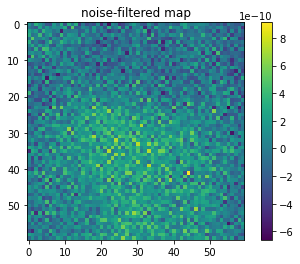

In [5]:
x0 = 2997
y0 = 1998
width = 30
patch = filtermap[x0-width:x0+width, y0-width:y0+width]

plt.imshow(patch)
plt.title('noise-filtered map')
plt.colorbar()
plt.show()